In [1]:
import ipympl
import matplotlib.pyplot as plt
import gym
import numpy as np
from tqdm import tqdm, trange, tqdm_notebook
import pandas as pd
import torch
import torch.nn as nn
import random
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from tensorboardX import SummaryWriter
from datetime import datetime
import glob, os

In [2]:
env = gym.make('MountainCar-v0')
env.seed(1); torch.manual_seed(1); np.random.seed(1)
PATH = glob.glob(os.path.expanduser('~/tboardlogs/'))
writer = SummaryWriter('{}{}'.format(PATH, datetime.now().strftime('%b%d_%H-%M-%S')))

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/hahamark/.local/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Furthest Position: -0.164068288377174


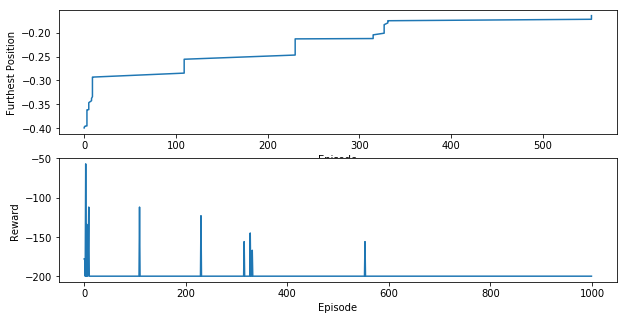

successful episodes: 0


In [3]:
max_position = -.4
positions = np.ndarray([0,2])
rewards = []
successful = []
for episode in range(1000):
    running_reward = 0
    env.reset()
    done = False
    for i in range(200):
        state, reward, done, _ = env.step(np.random.randint(0,3))
        # Give a reward for reaching a new maximum position
        if state[0] > max_position:
            max_position = state[0]
            positions = np.append(positions, [[episode, max_position]], axis=0)
            running_reward += 10
        else:
            running_reward += reward
        if done: 
            if state[0] >= 0.5:
                successful.append(episode)
            rewards.append(running_reward)
            break

print('Furthest Position: {}'.format(max_position))
plt.figure(1, figsize=[10,5])
plt.subplot(211)
plt.plot(positions[:,0], positions[:,1])
plt.xlabel('Episode')
plt.ylabel('Furthest Position')
plt.subplot(212)
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()
print('successful episodes: {}'.format(np.count_nonzero(successful)))

In [4]:
# I tried different weight initializations but found they did not perform well.
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight, 0, 1)

class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.state_space = env.observation_space.shape[0]
        self.action_space = env.action_space.n
        self.hidden = 100
        self.l1 = nn.Linear(self.state_space, self.hidden, bias=False)
        self.l2 = nn.Linear(self.hidden, self.action_space, bias=False)
    
    def forward(self, x):    
        model = torch.nn.Sequential(
            self.l1,
            self.l2,
        )
        return model(x)

In [11]:
def DQN(episodes):
    
    # Parameters
    steps = 200
    state = env.reset()
    epsilon = 0.3
    gamma = 0.99
    loss_history = []
    reward_history = []
    learning_rate = 0.001
    successes = 0
    position = []

    # Initialize Policy
    policy = Policy()
    loss_fn = nn.MSELoss()
    optimizer = optim.SGD(policy.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

    for episode in trange(episodes):
        episode_loss = 0
        episode_reward = 0
        state = env.reset()

        for s in range(steps):
            # Get first action value function
            Q = policy(Variable(torch.from_numpy(state).type(torch.FloatTensor)))

            # Choose epsilon-greedy action
            if np.random.rand(1) < epsilon:
                action = np.random.randint(0,3)
            else:
                _, action = torch.max(Q, -1)
                action = action.item()

            # Step forward and receive next state and reward
            state_1, reward, done, _ = env.step(action)

            # Adjust reward based on car position
            reward = state_1[0] + 0.5

            # Adjust reward for task completion
            if state_1[0] >= 0.5:
                reward += 1

            # Find max Q for t+1 state
            Q1 = policy(Variable(torch.from_numpy(state_1).type(torch.FloatTensor)))
            maxQ1, _ = torch.max(Q1, -1)

            # Create target Q value for training the policy
            Q_target = Q.clone()
            Q_target = Variable(Q_target)
            Q_target[action] = reward + torch.mul(maxQ1.detach(), gamma)

            # Calculate loss
            loss = loss_fn(Q, Q_target)

            # Update policy
            policy.zero_grad()
            loss.backward()
            optimizer.step()

            episode_loss += loss.item()
            episode_reward += reward

            if done:
                if state_1[0] >= 0.5:
                    # On successful epsisodes, adjust the following parameters
                    # Adjust epsilon
                    epsilon *= .95
                    # Adjust learning rate
                    scheduler.step()
                    # Record successful episode
                    successes += 1

                # Record history
                loss_history.append(episode_loss)
                reward_history.append(episode_reward)
                position.append(state_1[0])

                break
            else:
                state = state_1
                
    print('successful episodes: {:d} - {:.4f}%'.format(successes, successes/episodes*100))
    return position

In [14]:
def DoubleDQN(episodes):
    
    # Parameters
    steps = 200
    state = env.reset()
    epsilon = 0.3
    gamma = 0.99
    loss_history = []
    reward_history = []
    learning_rate = 0.001
    successes = 0
    position = []

    # Initialize Policy
    policy1 = Policy()
    policy2 = Policy()
    loss_fn = nn.MSELoss()
    optimizer = optim.SGD([
                {'params': policy1.parameters(), 'lr': learning_rate},
                {'params': policy2.parameters(), 'lr': learning_rate}
                ])
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

    for episode in trange(episodes):
        episode_loss = 0
        episode_reward = 0
        state = env.reset()

        for s in range(steps):
            # Get first action value function
            turn1 = random.choice([True, False])
            if turn1:
                Q = policy1(Variable(torch.from_numpy(state).type(torch.FloatTensor)))
            else:
                Q = policy2(Variable(torch.from_numpy(state).type(torch.FloatTensor)))
                
            # Choose epsilon-greedy action
            if np.random.rand(1) < epsilon:
                action = np.random.randint(0,3)
            else:
                _, action = torch.max(Q, -1)
                action = action.item()

            # Step forward and receive next state and reward
            state_1, reward, done, _ = env.step(action)

            # Adjust reward based on car position
            reward = state_1[0] + 0.5
            # Adjust reward for task completion
            if state_1[0] >= 0.5:
                reward += 1

            # Find max Q for t+1 state
            if turn1:
                Q1 = policy2(Variable(torch.from_numpy(state_1).type(torch.FloatTensor))).detach()
                Q2 = policy1(Variable(torch.from_numpy(state_1).type(torch.FloatTensor))).detach()
            else:
                Q1 = policy1(Variable(torch.from_numpy(state_1).type(torch.FloatTensor))).detach()
                Q2 = policy2(Variable(torch.from_numpy(state_1).type(torch.FloatTensor))).detach()
            
            _, a_prime = torch.max(Q1, -1)
            
            maxQ1 = Q2[a_prime]

            # Create target Q value for training the policy
            Q_target = Q.clone()
            Q_target = Variable(Q_target)
            Q_target[action] = reward + torch.mul(maxQ1.detach(), gamma)

            # Calculate loss
            loss = loss_fn(Q, Q_target)

            # Update policy
            policy1.zero_grad()
            policy2.zero_grad()
            loss.backward()
            optimizer.step()

            episode_loss += loss.item()
            episode_reward += reward

            if done:
                if state_1[0] >= 0.5:
                    # On successful epsisodes, adjust the following parameters
                    # Adjust epsilon
                    epsilon *= .95

                    # Adjust learning rate
                    scheduler.step()

                    # Record successful episode
                    successes += 1

                # Record history
                loss_history.append(episode_loss)
                reward_history.append(episode_reward)
                position.append(state_1[0])

                break
            else:
                state = state_1

    print('successful episodes: {:d} - {:.4f}%'.format(successes, successes/episodes*100))
    return position

In [ ]:
EPISODES = 1000
RUNS = 1

q_data_pos = np.zeros((RUNS, EPISODES))
dq_data_pos = np.zeros((RUNS, EPISODES))

for i in tqdm_notebook(range(RUNS)):
    position = DQN(EPISODES)
    q_data_pos[i, :] = position

    position = DoubleDQN(EPISODES)
    dq_data_pos[i, :] = position


  0%|          | 2/1000 [00:00<01:29, 11.12it/s]

successful episodes: 0 - 0.0000%


 22%|██▏       | 215/1000 [00:20<01:09, 11.25it/s]

In [ ]:
# Plot percentage actions left over episodes:
plt.plot(q_data_pos.mean(0), label='Q-learning')
plt.plot(dq_data_pos.mean(0), label='Double Q-learning')
plt.title('End position')
plt.legend()
plt.show()